## Term paper implementation
Name: Varun Machhale Kumar \\
Course: ECE570

In [ ]:
# Codes used

## https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_🤗_Trainer.ipynb (Fine tuning ViT hugging face model using hugging face trainer)
## https://github.com/yundaehyuck/Learning-to-resize-images-for-computer-vision-tasks/blob/main/resizing_network.ipynb (Resizing module Pytorch)

###Install required libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb
import wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 3.5 MB/s 
     |████████████████████████████████| 7.6 MB 30.9 MB/s 
     |████████████████████████████████| 182 kB 43.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.8 MB/s 
     |████████████████████████████████| 115 kB 63.9 MB/s 
     |████████████████████████████████| 212 kB 45.3 MB/s 
     |████████████████████████████████| 127 kB 55.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.6 MB/s 
     |████████████████████████████████| 168 kB 53.1 MB/s 
     |███████████████████

###Import dataset: CIFAR10 (1k images) or Beans Dataset

In [ ]:
from datasets import load_dataset

#                                                                                       # Load 1000 images of CIFAR10 dataset
# train_ds, test_ds = load_dataset('cifar10', split=['train[:1000]', 'test[:1000]'])
# splits = train_ds.train_test_split(test_size=0.1)                                     # split up training into training + validation
# train_ds = splits['train']
# val_ds = splits['test']                                                                                      

train_ds, test_ds = load_dataset('beans', split=['train', 'test'])                       # Use this for Beans dataset
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_ds, val_ds, test_ds

(Dataset({
     features: ['image_file_path', 'image', 'labels'],
     num_rows: 930
 }), Dataset({
     features: ['image_file_path', 'image', 'labels'],
     num_rows: 104
 }), Dataset({
     features: ['image_file_path', 'image', 'labels'],
     num_rows: 128
 }))

In [ ]:
train_ds.features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

In [ ]:
# id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}   # Use this for CIFAR10
id2label = {id:label for id, label in enumerate(train_ds.features['labels'].names)}    # Use this for Beans
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'angular_leaf_spot', 1: 'bean_rust', 2: 'healthy'}

### ViT Model
Run the following cells to get train and evaluate results from ViT Model

Used the GitHub code from [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_🤗_Trainer.ipynb
) to fine tune hugging face ViT models

#### Torchvision transforms

In [ ]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k") 

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    # examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]   # Use this for CIFAR10
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]   # Use this for Beans
    return examples

def val_transforms(examples):
    # examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]  ## Use this for CIFAR10
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]    ## Use this for Beans
    return examples


In [ ]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

#### Set arguments for Hugging Face Trainer


In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=3,                   # Change this to num_labels = 10 for CIFAR10
                                                  id2label=id2label,
                                                  label2id=label2id)

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-beans",           # Modify the name to test-CIFAR for CIFAR10
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to="wandb",  # Comment this parameter out if you dont want to use wandb
    logging_steps = len(train_ds)//64
)

PyTorch: setting up devices


In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # labels = torch.tensor([example["label"] for example in examples])    # Use this for CIFAR10
    labels = torch.tensor([example["labels"] for example in examples])     # Use this for Beans
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [ ]:
wandb.init()

#### Train the model

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 930
  Num Epochs = 50
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 750
  Number of trainable parameters = 85800963
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 104
  Batch size = 32
Saving model checkpoint to test-beans/checkpoint-15
Configuration saved in test-beans/checkpoint-15/config.json
Model weights saved in test-beans/checkpoint-15/pytorch_model.bin
Feature extractor saved in test-beans/checkpoint-15/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 104
  Batch size = 32
Saving model checkpoint to test-beans/checkpoint-30
Configuration saved in test-beans/checkpoint-30/config.json
Model weights saved in test-beans/checkpoint-30/pytorch_model.bin
Feature extractor saved in test-beans/checkpoint-30/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 104
  Batch size = 32
Saving model checkpoint to test-beans/checkpoint-45
Configuration saved in test-beans/checkpoint-45/config.json
Model weights saved in test-beans/checkpoint-45/pytorch_model.bin
Feature extractor saved in test-beans/checkpoint-45/preprocessor_config.json
***** Running Evaluation 

TrainOutput(global_step=750, training_loss=0.12615043898423514, metrics={'train_runtime': 2207.9155, 'train_samples_per_second': 21.061, 'train_steps_per_second': 0.34, 'total_flos': 3.603409813011456e+18, 'train_loss': 0.12615043898423514, 'epoch': 50.0})

#### Predictions on the test dataset:  ViT

In [ ]:
predictions = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 128
  Batch size = 32


In [ ]:
predictions[0].shape, predictions[1].shape

((128, 3), (128,))

In [ ]:
pred = np.argmax(predictions[0], axis=-1)

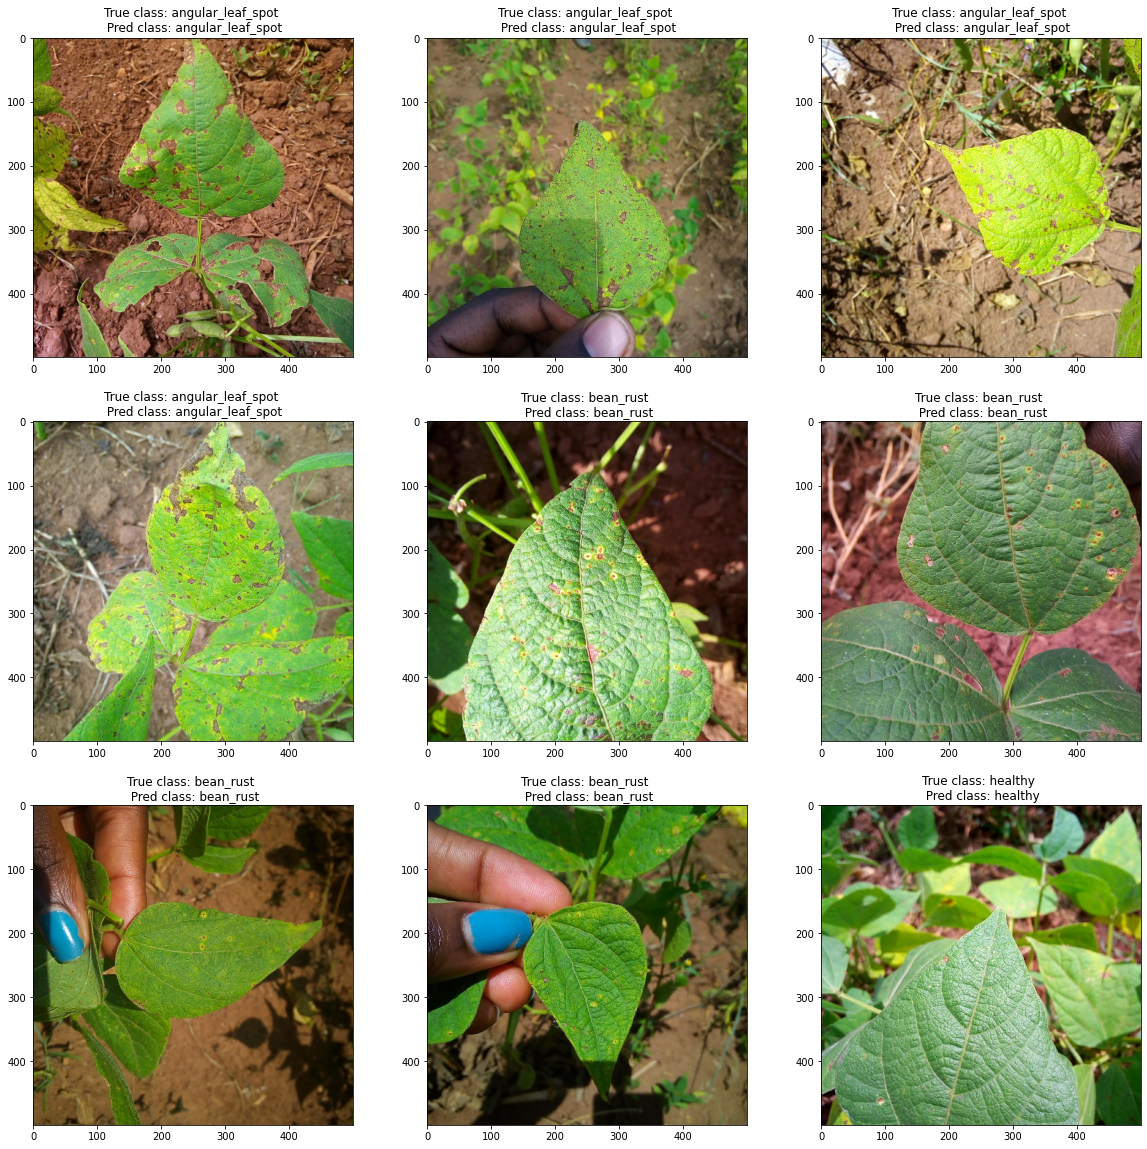

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,3, figsize = (20, 20))
ax = ax.ravel()
for i, idx in enumerate([0, 1, 2, 3, 64, 65, 77, 78, 90]):
  # ax[i].imshow(test_ds[idx]['img'])                                             # Use this for CIFAR10
  # ax[i].set_title(f"True class: {id2label[test_ds[idx]['label']]} \n Pred class: {id2label[pred[idx]]}")

  ax[i].imshow(test_ds[idx]['image'])                                             # Use this for Beans
  ax[i].set_title(f"True class: {id2label[test_ds[idx]['labels']]} \n Pred class: {id2label[pred[idx]]}")
plt.show()

In [ ]:
from google.colab import files

In [ ]:
# files.download('test-cifar-10/checkpoint-165') 

In [ ]:
wandb.finish()

### Learnable resizing network + ViT
Run the following cells to train and evaluate results from learnable resizer + ViT model

#### Torchvision transforms

In [ ]:
from transformers import ViTForImageClassification

ViTmodel = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=3,        ## Change this to num_labels=10 for CIFAR10
                                                  id2label=id2label,
                                                  label2id=label2id)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ViTmodel.num_parameters()

85800963

In [ ]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [ ]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            # RandomResizedCrop(feature_extractor.size * 2),                    ## Uncomment this for CIFAR 10
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [   
            # Resize(feature_extractor.size*2),                                 ## Uncomment this for CIFAR10
            CenterCrop(feature_extractor.size*2),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    # examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]     # For CIFAR10
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]     # For Beans
    return examples

def val_transforms(examples):
    # examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]       # For CIFAR10
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]       # For Beans
    return examples

In [ ]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
# train_ds[0]['img'].size ## For CIFAR10 dataset
train_ds[0]['image'].size

(500, 500)

#### Resizer network
Code used from: https://github.com/yundaehyuck/Learning-to-resize-images-for-computer-vision-tasks/blob/main/resizing_network.ipynb


In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self,num_channels=16):
        super(ResBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self,x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        
        out = self.leakyrelu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        
        return out
        
def make_block(r,n):
  residual = []
  
  for i in range(r):
      block = ResBlock(num_channels=n)
      residual.append(block)
  
  return nn.Sequential(*residual)
  
class ResizingNetwork(nn.Module):
  def __init__(self,r=1, n=3):
      super(ResizingNetwork, self).__init__()
      
      self.conv1 = nn.Conv2d(in_channels=3,out_channels=n,kernel_size=7,stride=1,padding=3)
      self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
      
      self.conv2 = nn.Conv2d(n,n,kernel_size=1,stride=1)
      self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
      self.bn1 = nn.BatchNorm2d(n)
      
      
      self.resblock = make_block(r,n)
      
      
      self.conv3 = nn.Conv2d(n,n,kernel_size=3,stride=1,padding=1)
      self.bn2 = nn.BatchNorm2d(n)
      
      self.conv4 = nn.Conv2d(n,out_channels=3,kernel_size=7,stride=1,padding=3)
      
  
  def forward(self,x):
      
      residual = F.interpolate(x,size=(224, 224),mode='bilinear')

      out = self.conv1(x)
      out = self.leakyrelu1(out)
      
      out = self.conv2(out)
      out = self.leakyrelu2(out)
      out = self.bn1(out)
      
      out_residual = F.interpolate(out,size = (224, 224),mode='bilinear')
      
      out = self.resblock(out_residual)
      
      out = self.conv3(out)
      out = self.bn2(out)
      out += out_residual
      
      out = self.conv4(out)
      out += residual
      
      return out

#### Custom Model: Resizer_ViT model
Combine Resizer network and ViT model

In [ ]:
from transformers.modeling_outputs import ImageClassifierOutput

class Resizer_ViT(nn.Module):
  def __init__(self): 
    super(Resizer_ViT,self).__init__() 

    self.model = ViTmodel
    self.resizer = ResizingNetwork()
  def forward(self, pixel_values=None, labels=None):

    x = self.resizer(pixel_values)    # Pass the input image through resizer network
    outputs = self.model(pixel_values=x, labels=labels) # Pass the resized image to ViT model
    
    return ImageClassifierOutput(outputs.loss, outputs.logits, outputs.hidden_states, outputs.attentions)

In [ ]:
my_model = Resizer_ViT()

In [ ]:
from torchsummary import summary
summary(my_model.resizer.to('cuda'), (3,500, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 500, 500]             444
         LeakyReLU-2          [-1, 3, 500, 500]               0
            Conv2d-3          [-1, 3, 500, 500]              12
         LeakyReLU-4          [-1, 3, 500, 500]               0
       BatchNorm2d-5          [-1, 3, 500, 500]               6
            Conv2d-6          [-1, 3, 224, 224]              84
       BatchNorm2d-7          [-1, 3, 224, 224]               6
         LeakyReLU-8          [-1, 3, 224, 224]               0
            Conv2d-9          [-1, 3, 224, 224]              84
      BatchNorm2d-10          [-1, 3, 224, 224]               6
         ResBlock-11          [-1, 3, 224, 224]               0
           Conv2d-12          [-1, 3, 224, 224]              84
      BatchNorm2d-13          [-1, 3, 224, 224]               6
           Conv2d-14          [-1, 3, 2

#### Set arguments for Hugging Face Trainer

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-beans-Re+ViT",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to="wandb",
    logging_steps = len(train_ds)//64
)

## added report_to parameter to visualize training using wandb API
## modified batch size as per requirements

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # labels = torch.tensor([example["label"] for example in examples])          # Use this for CIFAR10 dataset
    labels = torch.tensor([example["labels"] for example in examples])           # Use this for Beans dataset
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


In [ ]:
new_trainer = Trainer(
    my_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

#### Train the model

In [ ]:
new_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 930
  Num Epochs = 50
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 750
  Number of trainable parameters = 85802139
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: varunmkmr. Use `wandb login --relogin` to force relogin


***** Running Evaluation *****
  Num examples = 104
  Batch size = 32
Saving model checkpoint to test-beans-Re+ViT/checkpoint-15
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Feature extractor saved in test-beans-Re+ViT/checkpoint-15/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 104
  Batch size = 32
Saving model checkpoint to test-beans-Re+ViT/checkpoint-30
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Feature extractor saved in test-beans-Re+ViT/checkpoint-30/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 104
  Batch size = 32
Saving model checkpoint to test-beans-Re+ViT/checkpoint-45
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Feature extractor saved in test-beans-Re+ViT/checkpoint-45/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 104
  Batch size = 32
Saving model checkpoint to test-beans-Re+ViT/checkpoint-60
Trainer.model is not a

TrainOutput(global_step=750, training_loss=0.1407334595521291, metrics={'train_runtime': 2721.0948, 'train_samples_per_second': 17.089, 'train_steps_per_second': 0.276, 'total_flos': 0.0, 'train_loss': 0.1407334595521291, 'epoch': 50.0})

#### Predictions on the test dataset: Resizer_ViT

In [ ]:
predictions = new_trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 128
  Batch size = 32


In [ ]:
predictions[0].shape, predictions[1].shape

((128, 3), (128,))

In [ ]:
pred = np.argmax(predictions[0], axis=-1)

##### Visualize results

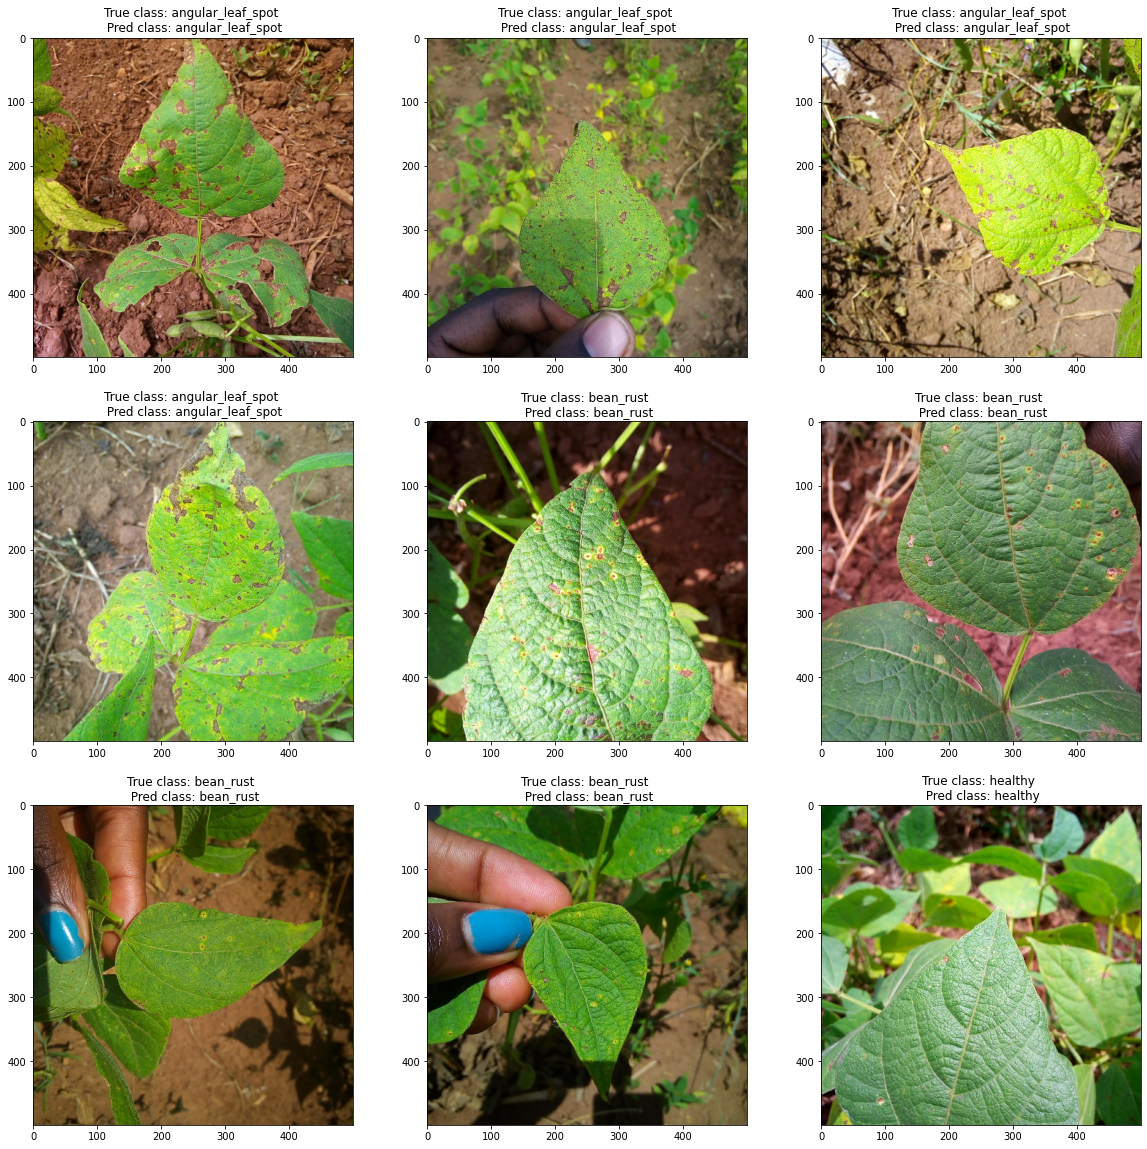

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,3, figsize = (20, 20))
ax = ax.ravel()
for i, idx in enumerate([0, 1, 2, 3, 64, 65, 77, 78, 90]):
  # ax[i].imshow(test_ds[idx]['img'])                           # Use this for CIFAR10 dataset
  # ax[i].set_title(f"True class: {id2label[test_ds[idx]['label']]} \n Pred class: {id2label[pred[idx]]}")
  
  ax[i].imshow(test_ds[idx]['image'])                          # Use this for Beans dataset
  ax[i].set_title(f"True class: {id2label[test_ds[idx]['labels']]} \n Pred class: {id2label[pred[idx]]}")
plt.show()

##### Visualize learnable resizer output

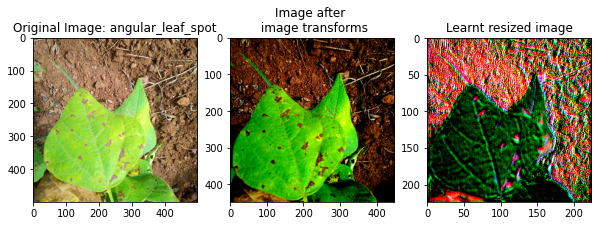

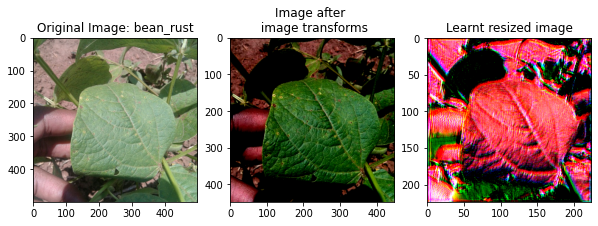

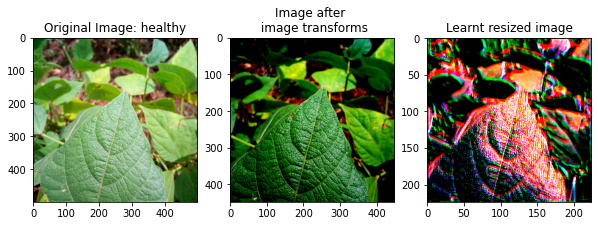

In [ ]:
# Use this for Beans dataset

for i in [10, 60, 90]:
  img = new_trainer.model.resizer(test_ds[i]['pixel_values'].unsqueeze(0).to('cuda'))
  fig, axs = plt.subplots(1,3, figsize = (10,10))
  axs[0].imshow(test_ds[i]['image'])
  axs[1].imshow(test_ds[i]['pixel_values'].squeeze().permute(1,2,0))
  axs[2].imshow(img.detach().cpu().squeeze().permute(1,2,0))
  axs[0].set_title(f"Original Image: {id2label[test_ds[i]['labels']]}")
  axs[1].set_title('Image after \n image transforms')
  axs[2].set_title('Learnt resized image')
plt.show()

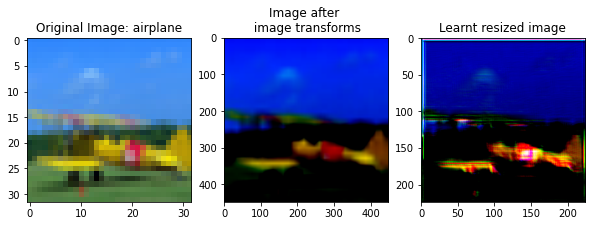

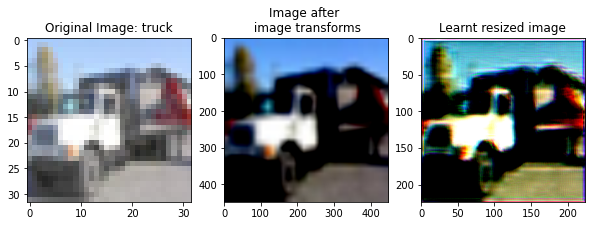

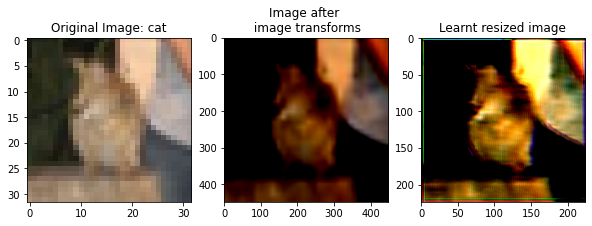

In [ ]:
## Use this for CIFAR10 dataset
## Results for CIFAR10 (1k images)

# for i in range(44, 47):
#   img = new_trainer.model.resizer(test_ds[i]['pixel_values'].unsqueeze(0).to('cuda'))
#   fig, axs = plt.subplots(1,3, figsize = (10,10))
#   axs[0].imshow(test_ds[i]['img'])
#   axs[1].imshow(test_ds[i]['pixel_values'].squeeze().permute(1,2,0))
#   axs[2].imshow(img.detach().cpu().squeeze().permute(1,2,0))
#   axs[0].set_title(f"Original Image: {id2label[test_ds[i]['label']]}")
#   axs[1].set_title('Image after \n image transforms')
#   axs[2].set_title('Learnt resized image')
# plt.show()

In [ ]:
fig.savefig('Resizer.svg', image_format='svg', dpi=1200)